In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 安裝cv2與tensorflow套件後用這些套件建構深度學習模型
#install cv2 and tensorflow package and use the package to establish the deep learning model

import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

# 下載資料load data 並分解成 訓練training, 測試test 與 驗證validation 集
# down load the data and divide it into training test and validation set

path = '/content/drive/MyDrive/AI_HW3/chest_xray/'


# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files have extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be a redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])



In [6]:
#preprocess data
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img
#stored in np.array
def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [7]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [8]:
#data preprocessing and data augmentation
datagenerator = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    zoom_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False
)
datagenerator.fit(X_train)

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [10]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [11]:
optimizer = Adam(lr = 0.0001, decay= 1e-5)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [12]:
callback = EarlyStopping(monitor = 'loss', patience = 5)
history = model.fit(datagenerator.flow(X_train,y_train, batch_size = 4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/100
1304/1304 [==============================] - 57s 34ms/step - loss: 0.6684 - accuracy: 0.5213 - val_loss: 0.3339 - val_accuracy: 0.8590
Epoch 2/100
1304/1304 [==============================] - 44s 33ms/step - loss: 0.3432 - accuracy: 0.8192 - val_loss: 0.3690 - val_accuracy: 0.8590
Epoch 3/100
1304/1304 [==============================] - 43s 33ms/step - loss: 0.2682 - accuracy: 0.8625 - val_loss: 0.4784 - val_accuracy: 0.7997
Epoch 4/100
1304/1304 [==============================] - 43s 33ms/step - loss: 0.2538 - accuracy: 0.8683 - val_loss: 0.3352 - val_accuracy: 0.8654
Epoch 5/100
1304/1304 [==============================] - 43s 33ms/step - loss: 0.2527 - accuracy: 0.8760 - val_loss: 0.2841 - val_accuracy: 0.8910
Epoch 6/100
1304/1304 [==============================] - 43s 33ms/step - loss: 0.2171 - accuracy: 0.8921 - val_loss: 0.3100 - val_accuracy: 0.8958
Epoch 7/100
1304/1304 [==============================] - 43s 33ms/step - loss: 0.1955 - accuracy: 0.9013 - val_loss: 0

In [13]:
print("Test Accuracy: {0:.2f}%".format(model.evaluate(X_test,y_test)[1]*100))

20/20 [==============================] - 1s 29ms/step - loss: 0.3232 - accuracy: 0.9119
Test Accuracy: 91.19%


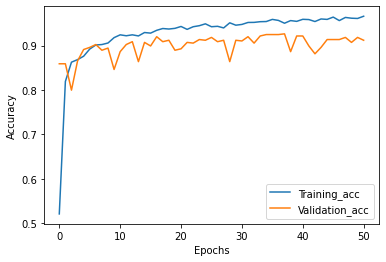

In [14]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc,label = "Training_acc")
plt.plot(val_acc,label = 'Validation_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

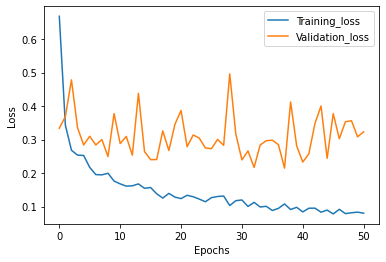

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label = 'Training_loss')
plt.plot(val_loss,label = 'Validation_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

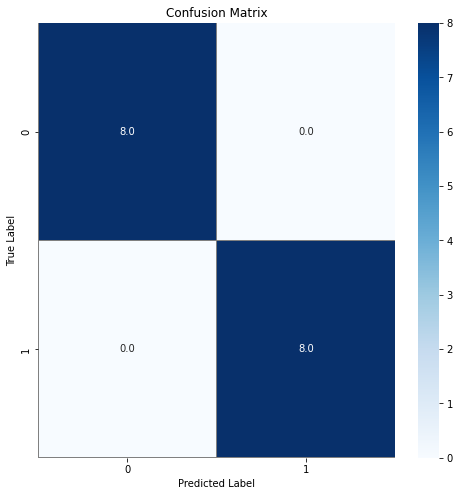

In [16]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(y_val, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_mtx, annot = True, linewidths = 0.01,cmap = "Blues", linecolor = "gray", fmt= '.1f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

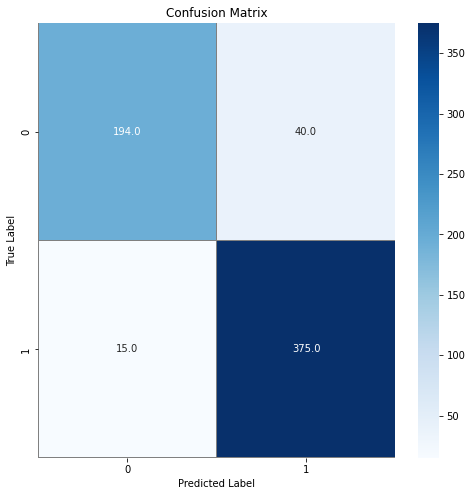

In [17]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_mtx, annot = True, linewidths = 0.01, cmap = "Blues", linecolor = "gray", fmt= '.1f',ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()